***Import libraires and data, set up stuff***

Packages (conda or pip installation) needed for preprocessing:

```
scanpy > 1.4.1
scvelo
rpy2
r-scran
r-sctransform
scrublet
seaborn
anndata2ri
...
```

Packages fuckups tips:
* If there is an error in calculating neighbourhoods, then it is likely to be the annoy package. Use pip3 to force annoy to install with version 1.13.0. It will break coherence in your conda environment, so everytime you use conda install you need afterwards to downgrade your annoy packae with pip.
* If there is a pandas error in opening an h5ad dataset, then use anndata down to version 0.7.4 or eventually below that if the problem persists. It is a bug in the newest version last time I checked. 

In [1]:
%run ../analysisLibraries

In [2]:
%matplotlib inline

In [3]:
%load_ext rpy2.ipython

Download scanpy support from the repository on github and install it before use

```
git clone https://github.com/SamueleSoraggi/scanpySupport.git
cd scanpySupport
python3 setup.py
```

In [4]:
import scanpySupport as scs

Read the expression data

In [6]:
adata = sc.read_10x_mtx('../cellranger/cellranger_nuclei_HEPES/outs/filtered_feature_bc_matrix/', cache=True)

In [7]:
adata.shape

(7699, 34549)

Read the spliced/unspliced counts

In [5]:
ldata = sc.read_loom('../cellranger/velocyto_nuclei_HEPES/possorted_genome_bam_TTT6X.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
ldata.var_names_make_unique()

Merge the two datasets

In [9]:
adata_flt = scv.utils.merge(adata,ldata)

Chromosome names

In [10]:
np.unique(adata_flt.var['Chromosome'])

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '21', '22', '2A', '2B', '3', '4', '5', '6', '7', '8', '9',
       'MT', 'Un', 'X', 'Y'], dtype=object)

All observations and variables and matrices

In [11]:
adata_flt

AnnData object with n_obs × n_vars = 7699 × 34549 
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [12]:
!mkdir -p write/qc

In [13]:
adata_flt.write_h5ad('./write/qc/adata_01.h5ad')

... storing 'feature_types' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


cleanup after merging and saving

In [14]:
del adata_flt, ldata

Calculate MT-genes percentage, Visualize QC statistics for filtering. Cleanup a lot of the extra crap that takes space in the `.var` section. Keep chromosomes. Mito chromosome is assumed to be called `MT`. If not change its name in the cathegorical pandas array defined below

In [5]:
#reading the data again should make all matrices sparse. Worth waiting reading time.
adata = sc.read('./write/qc/adata_01.h5ad')

OSError: Unable to open file (unable to open file: name = 'write/qc/adata_01.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [21]:
chrom = adata.var['Chromosome']
scv.utils.cleanup(adata, 'var')
adata.var['chromosome'] = pd.Categorical(chrom)

In [22]:
#calculate quality measures
adata = scs.pp.calculateQC(adata)

Calculating spliced and unspliced proportions


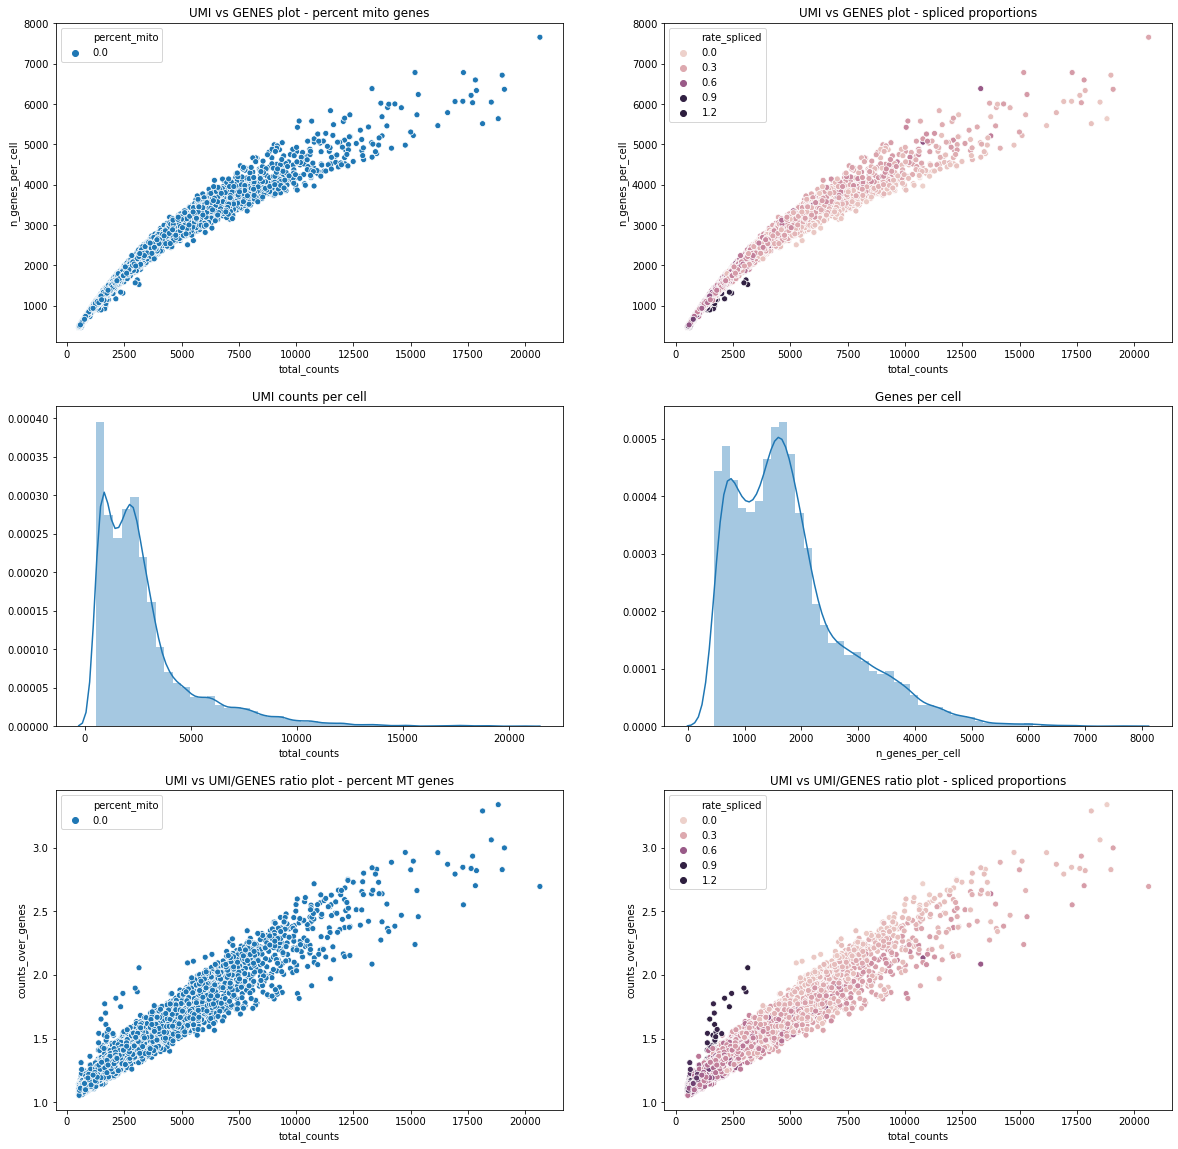

In [23]:
#do some plots of quality measures
scs.pl.plotQC(adata)

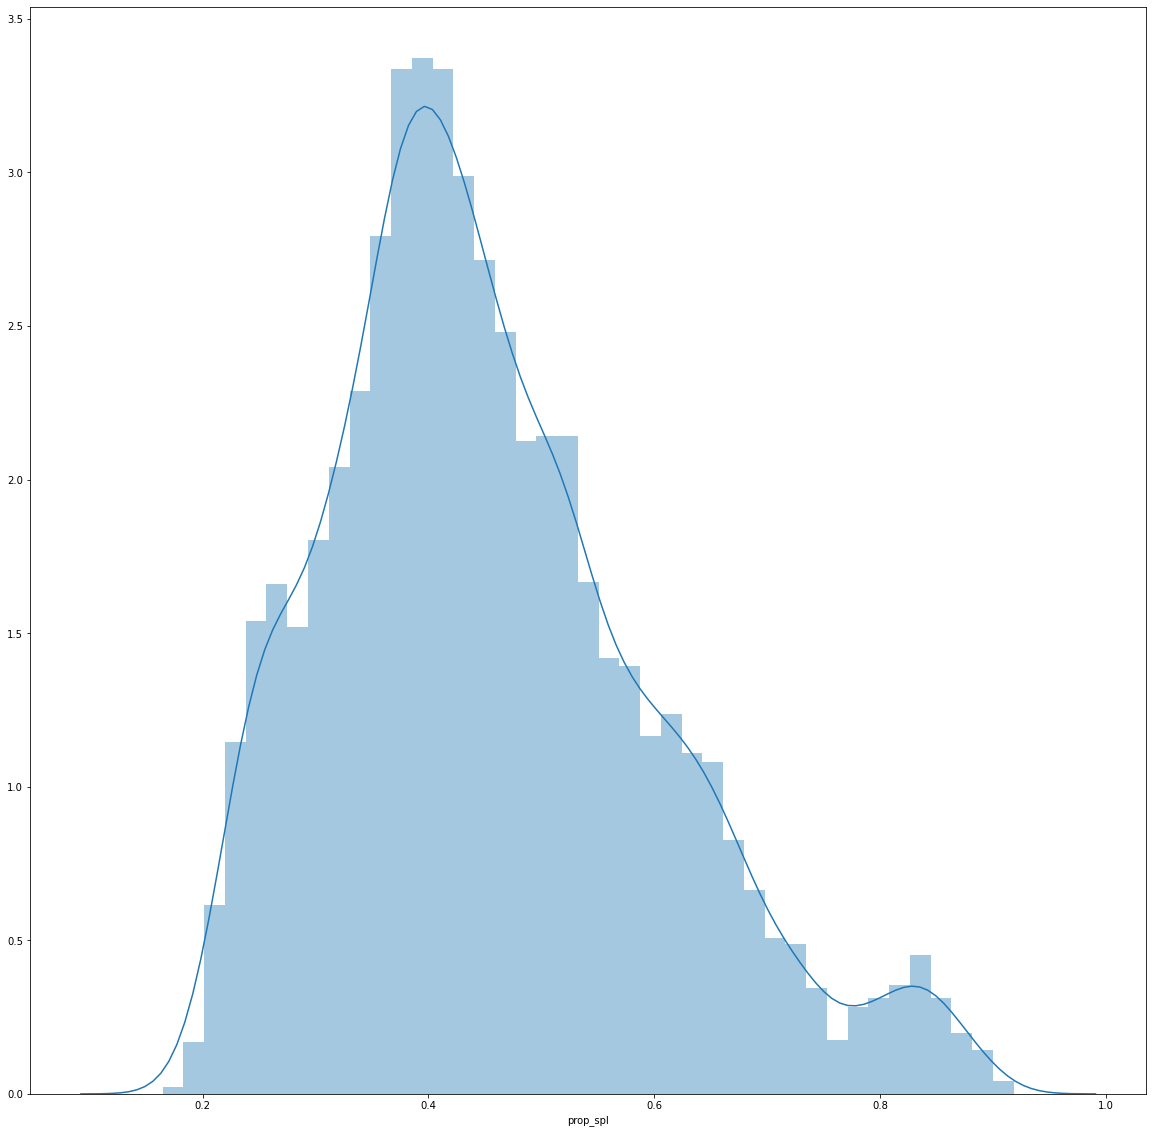

In [24]:
#look at spliced proportions in detail to decide what to remove
plt.rcParams["figure.figsize"] = (6,6)
sns.distplot(adata.obs['prop_spl'])

In [25]:
#spliced proportions filtering. One can avoid being too rough in filtering, the later filtering based on PCA decomposition is going to help removing remaining outliers with spliced proportions out of range (since those cells also show other abnormal quality measures).
adata=adata[adata.obs['prop_spl']<.75].copy()

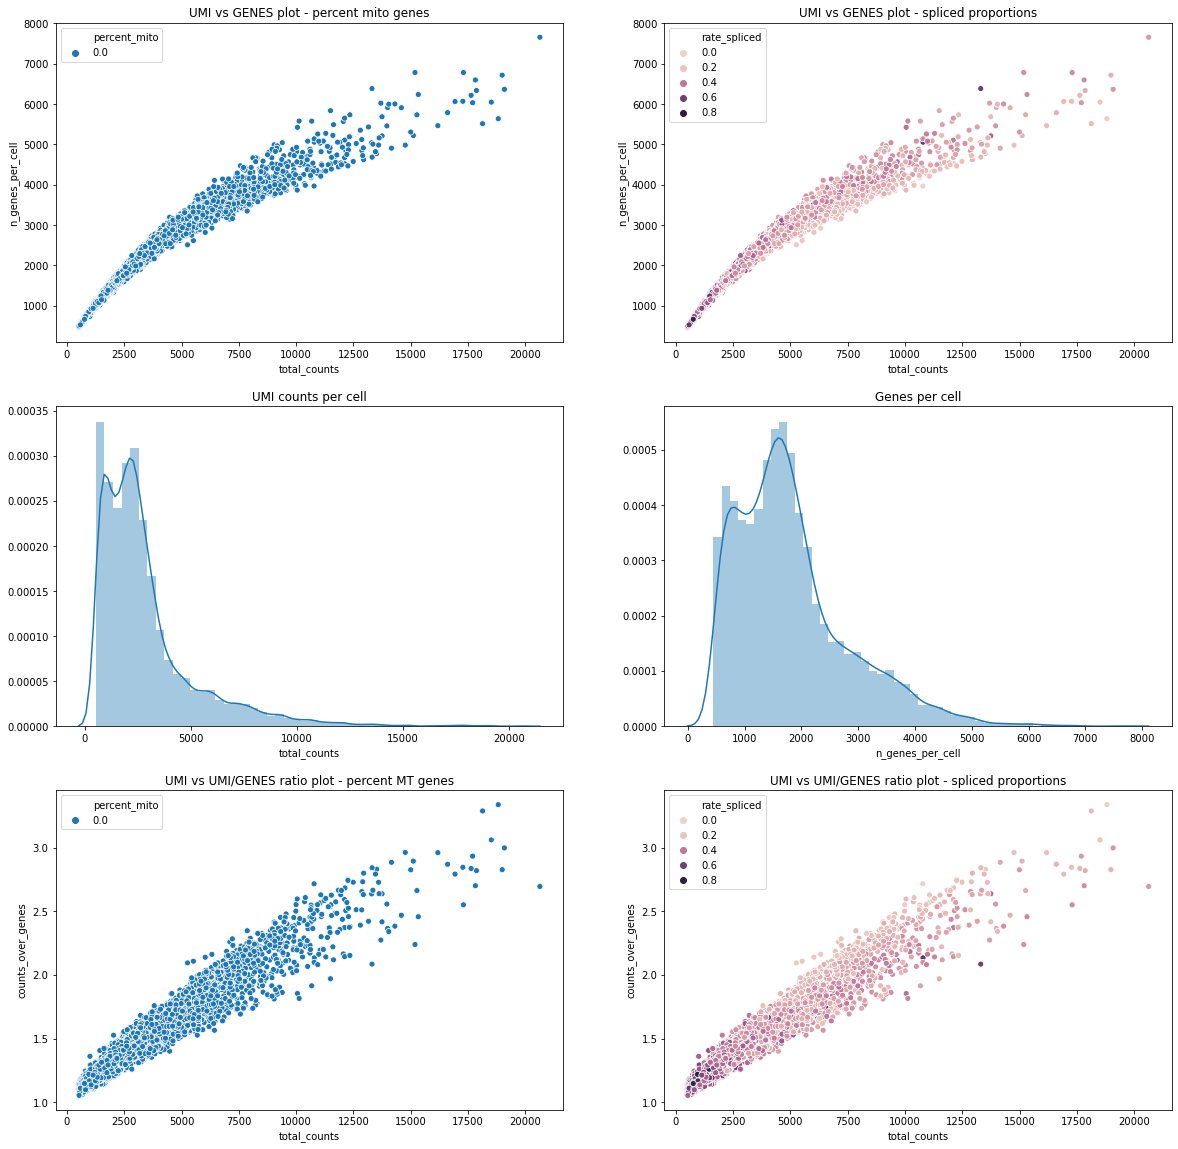

In [26]:
#how it does look like after filtering by spliced proportions
scs.pl.plotQC(adata)

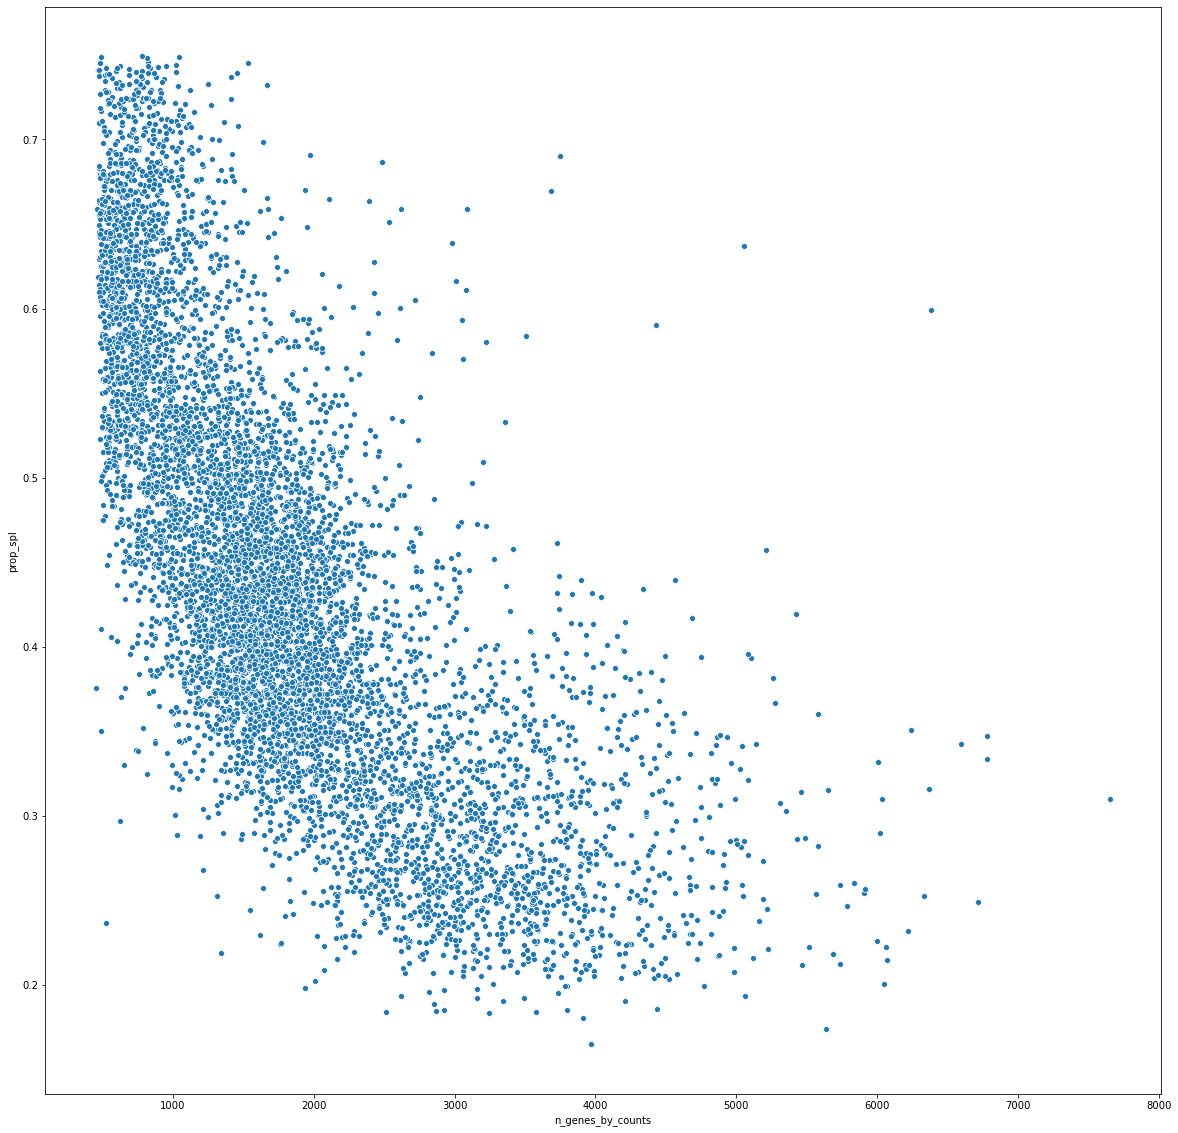

In [27]:
#Here we can see if there are clls with few observed genes but high spliced proportions. Those are likely remaining outliers. We can remove them now or let the PCA filtering take care of most of them.
sns.scatterplot(x=adata.obs['n_genes_by_counts'],y=adata.obs['prop_spl'])

In [28]:
#looks like cells with <1000 genes often get very high spliced proportions. Let's try removing them.
sc.pp.filter_cells(adata, min_genes=1000)

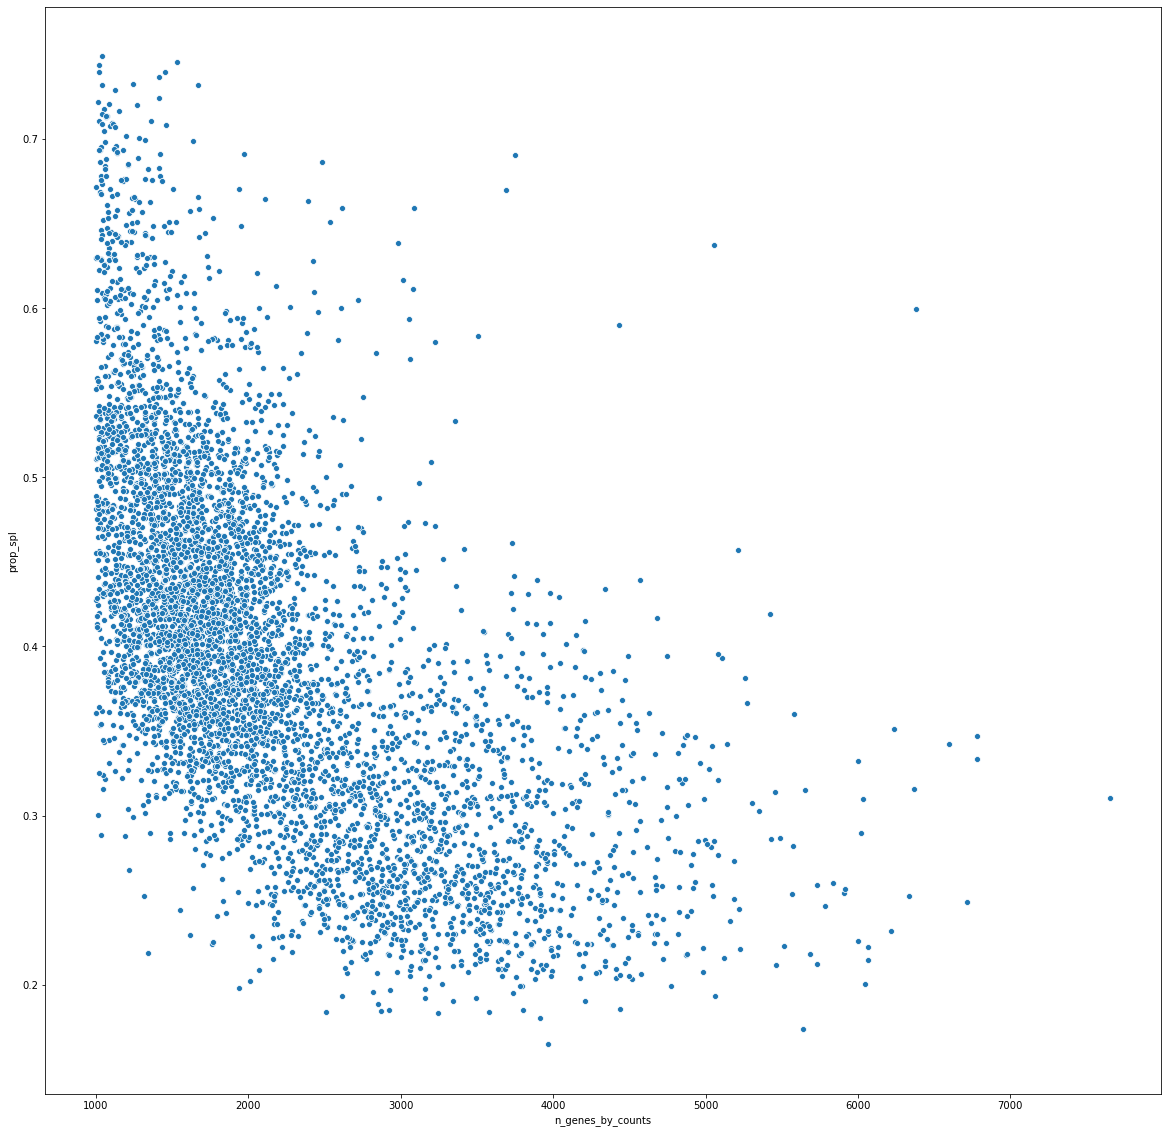

In [29]:
#this is what is left
sns.scatterplot(x=adata.obs['n_genes_by_counts'],y=adata.obs['prop_spl'])

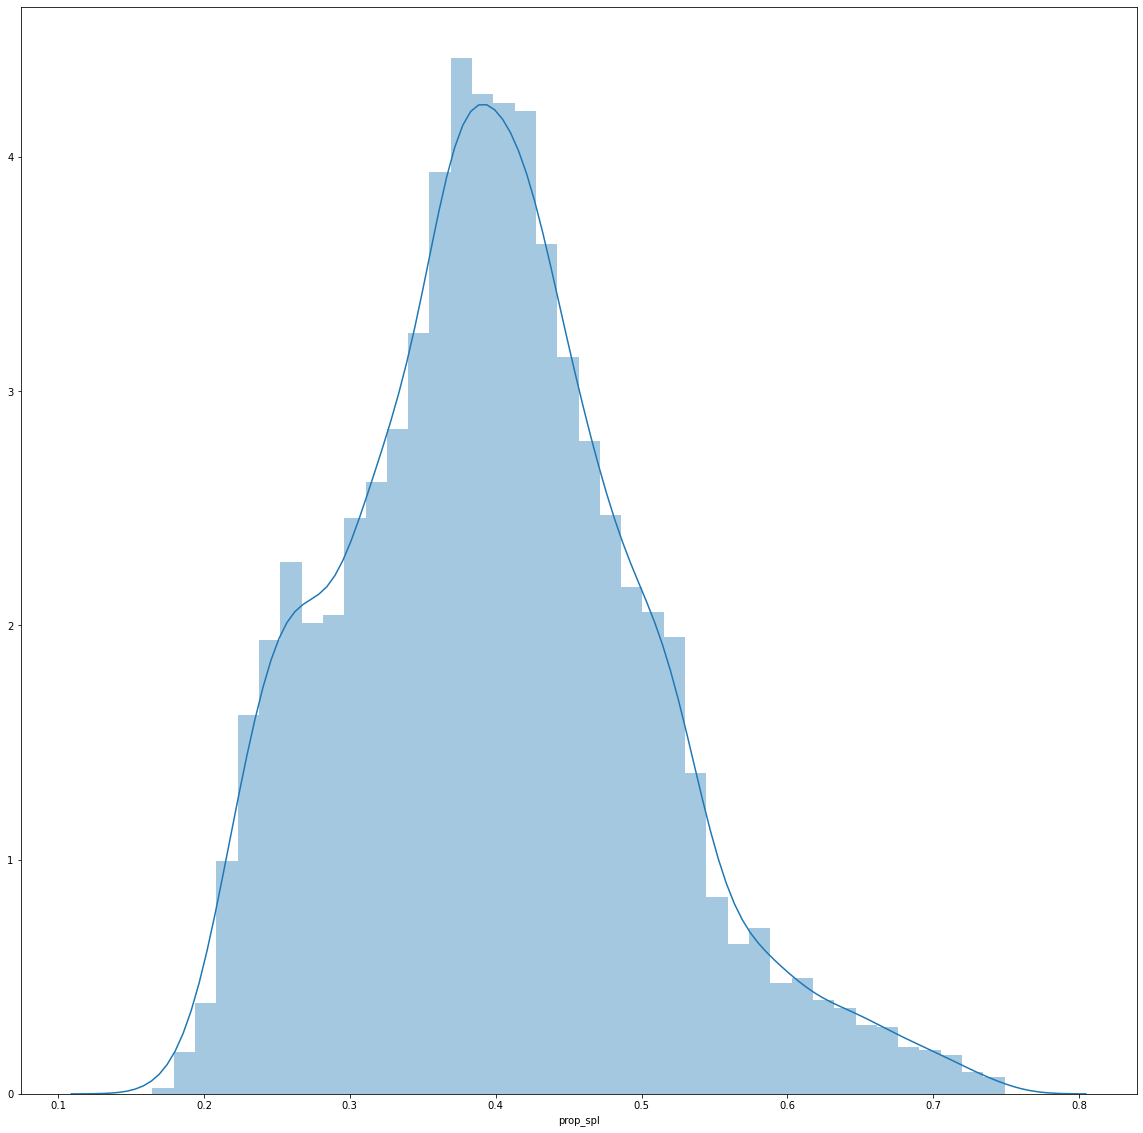

In [30]:
#this is what is left
sns.distplot(adata.obs['prop_spl'])

In [31]:
#in case you want to filter more the tail of spiced proportions
adata=adata[adata.obs['prop_spl']<.6].copy()

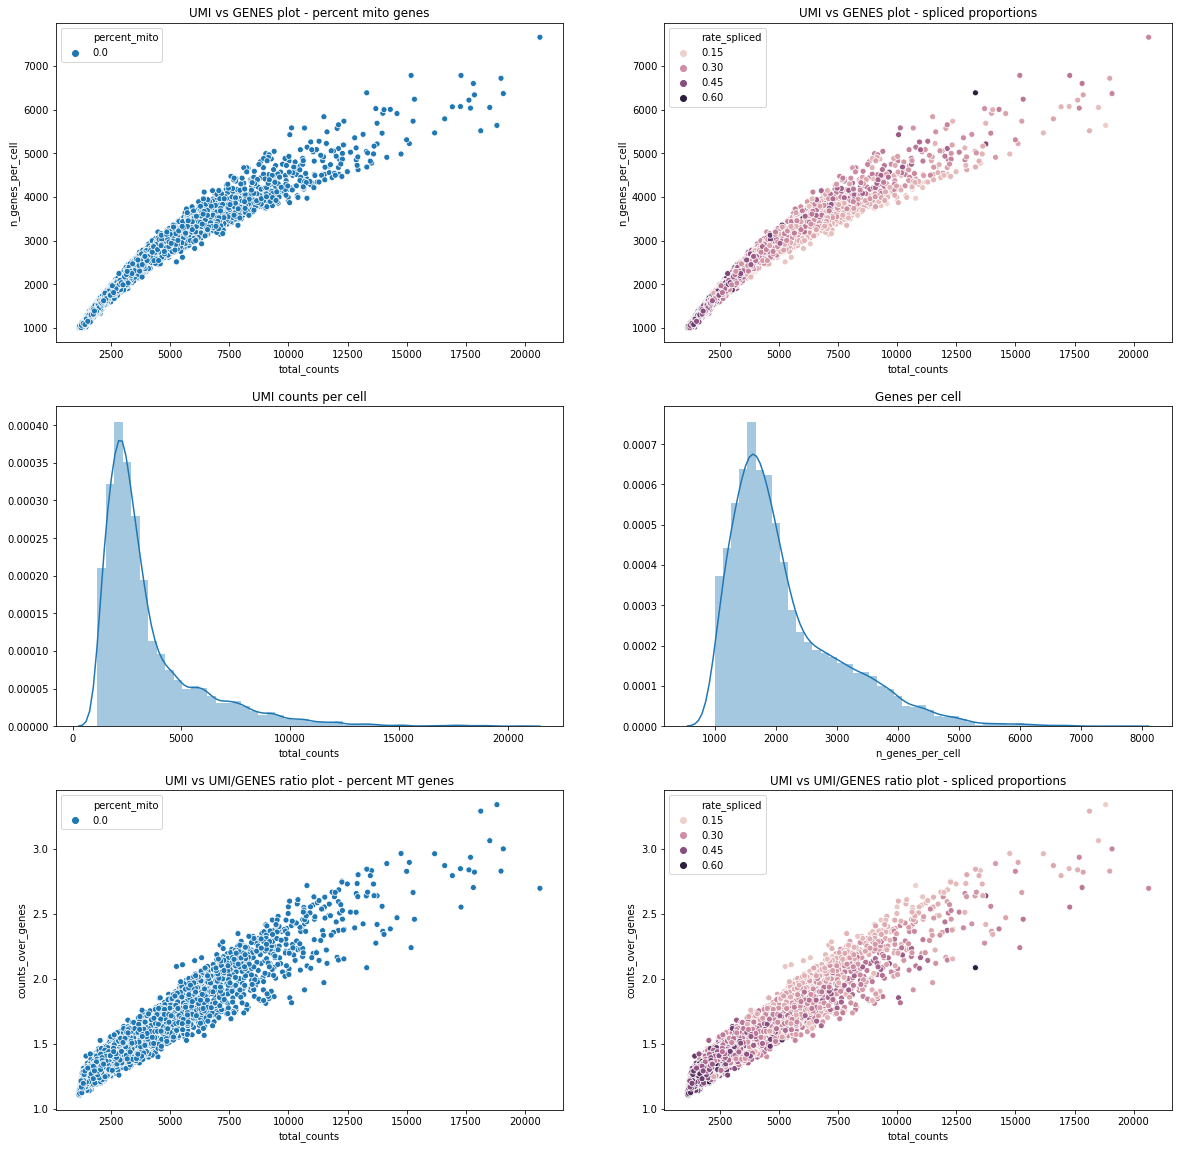

In [32]:
#quality measures on filtered data
scs.pl.plotQC(adata)

In [33]:
adata.shape

AnnData object with n_obs × n_vars = 5567 × 34549 
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'scaled_CDR', 'prop_spl', 'prop_unspl', 'n_genes'
    var: 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [34]:
adata.write('./write/qc/adata_02.h5ad')

Detection of doublets for the sample. Choose an expected rate of 0.06 for start (often a typical value for scRNAseq experiments, at least on whole cells experiments), and then try to match it to the overall estimated doublet rate by running again `scs.pp.scrublet`. Look for the rightmost mode in the plot of observed transcriptomes, and choose a doublet score as filtering threshold, then run again the function for a last time, so that cells to filter out are selected. To be sure you have a good expected rate chosen, you should have a rightmost mode also in the plot of simulated doublets. If you cannot see such a mode, do not choose any doublet score and let the function choose one, so you filter out likely very few cells afterwards. Alternatively, do not filter out any data point in the command following the scrublet analysis.

In [35]:
adata = sc.read('./write/qc/adata_02.h5ad')

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.12
Detected doublet rate = 11.0%
Estimated detectable doublet fraction = 70.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 15.7%
Elapsed time: 8.1 seconds
Nr of predicted doublets  384
Doublets indices saved in adata.obs["predicted_doublets"]


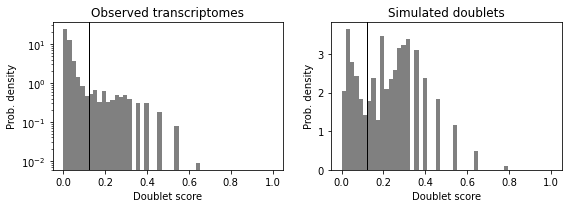

In [36]:
scs.pp.scrublet(adata, expected_rate=0.06, doublet_score=.2)

In [37]:
adata = adata[np.invert(adata.obs['predicted_doublets'])].copy()

In [38]:
adata.shape

AnnData object with n_obs × n_vars = 5183 × 34549 
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'scaled_CDR', 'prop_spl', 'prop_unspl', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [39]:
adata.write('./write/qc/adata_03.h5ad')

In [6]:
adata = sc.read('./write/qc/adata_03.h5ad')

Look into the genes and filter them. The adaptive genes filtering needs the MAST (R package, can be found on conda) package. By default it is commented and only standard genes filtering is used. The MAST filtering will be implemented into the scanpySupport package because it is messy to copy-paste it.

In [7]:
#just remove genes observed in less than 10 cells
sc.pp.filter_genes(adata,min_cells=10)

In [8]:
adata

AnnData object with n_obs × n_vars = 5183 × 22936 
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'scaled_CDR', 'prop_spl', 'prop_unspl', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [9]:
#adata.layers['raw'] = adata.X.todense().copy()

In [10]:
#sc.pp.log1p(adata)
#rawMatrix = np.array( adata.X.todense().T )
#variables = adata.var.copy()
#observations = adata.obs[ ['scaled_CDR'] ].copy()

In [11]:
#%%R -i rawMatrix -i observations -i variables
#library(MAST)
##Set up the CellDataSet data structure
#pd <- DataFrame(data = observations)
#fd <- DataFrame(data = variables)
#colnames(rawMatrix) <- rownames(pd) #cell names
#rownames(rawMatrix) <- rownames(fd) #gene names

In [12]:
#%%R 
##create sc experiment (DESEQ or SCATER object). MAST need logs and so we make the log here. 
#sce_dge <- SingleCellExperiment(assays = list(counts = as.matrix(rawMatrix) ), colData = observations)
##convert sc experiment to sc assay (MAST object). check_sanity=FALSE avoids looking for log or not in the data.
#sca_dge <- SceToSingleCellAssay(sce_dge, class = "SingleCellAssay", check_sanity = FALSE)

In [13]:
#%%R
#library(ggplot2)
#scaSample <- sca_dge[sample(which(freq(sca_dge)>.01), 20),]
#flat <- as(scaSample, 'data.table')
#ggplot(flat, aes(x=value))+geom_density() #+facet_wrap(~symbolid, scale='free_y')

In [14]:
#%%R
#thres <- thresholdSCRNACountMatrix(assay(sca_dge), nbins = 20, min_per_bin = 30)
#par(mfrow=c(5,4))
#plot(thres)

In [15]:
#%%R
#freq_expressed = .01
#assays(sca_dge) <- list(thresh=thres$counts_threshold, tpm=assay(sca_dge))
#expressed_genes <- freq(sca_dge) > freq_expressed
#sca_dge <- sca_dge[expressed_genes,]

In [16]:
#%%R -o cells -o genes
#cells = colnames(sca_dge)
#genes = rownames(sca_dge)

In [17]:
#adata2 = adata[:,genes].copy()
#adata2 = adata2[cells,:].copy()

In [18]:
#adata2.write('./write/many/qc/adata_04.h5ad')

In [ ]:
#del adata
#del adata2

PCA based filtering with QC-measures. There can be a problem with libRlapack when using conda. Try to find the missing file (in my error it is called `libRlapack.so` or something similar. Then copy it in the folder staten in the error message. It is some fuckup due to repository chosen in conda for installing r-base and other R packages.

In [19]:
#adata = sc.read('./write/many/qc/adata_04.h5ad')

In [20]:
#Run PCA filtering
adata = scs.pp.pca_outliers(adata)

Loading objects into R
Calculate PCA outliers
Nr of outliers detected: 20

In [44]:
sc.pp.filter_genes(adata,min_cells=10)

In [45]:
adata.write('./write/qc/adata_04.h5ad')

In [5]:
adata = sc.read('./write/qc/adata_04.h5ad')

In [46]:
adata.shape

(5163, 22929)

Loading objects into R
Calculate PCA covariates


Transforming to str index.


using the R command
getVarianceExplained(sce, exprs_values = "counts", variables = c("data.total_counts","data.n_genes_by_counts","data.percent_mito","data.scaled_CDR","data.prop_spl") )


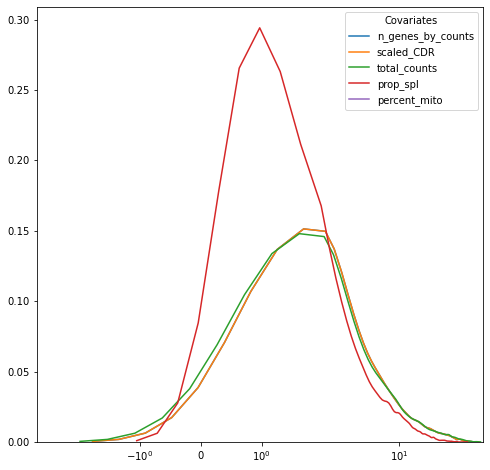

In [47]:
#look at the effect of some covariates on each gene in the data. Tails are not that important, mostly look at peaks. X axis is the % variability for each gene when linearly regressing a covariate with counts of a gene over the cells. High % variability (peak >= 10^1 on the X axis might mean it will be necessary to keep into account the covariate into the normalization and differential expression procedures)
adata = scs.pp.pca_covariates(adata, 
                              covariates=['total_counts',
                                          'n_genes_by_counts',
                                          'percent_mito',
                                          'scaled_CDR',
                                          'prop_spl'])

In [48]:
adata.write('./write/qc/adata_05.h5ad')